This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

The core model is Conv1D.

# todos:
* regularization
* save/load model
* load pre-trained embedding
* mini-batching # Done
* make sure it runs on GPU # Done

In [1]:
%matplotlib inline
from __future__ import print_function, division
from io import open
import string
import re
import random
import sklearn 
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data

use_cuda = torch.cuda.is_available()

import sys, random
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle

from torchviz import make_dot, make_dot_from_trace

# for windows only    
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


In [2]:
use_cuda 

False

In [3]:
# prepare data: load the input file containing list of list of list, and corresponding label file
# and output the splitted training, valid and Test sets

def data_load_split_VT(seqFile = 'pytorch_ehr-master/pytorch_ehr-master/data/cerner/hospital_data/h143.visits', labelFile = 'pytorch_ehr-master/pytorch_ehr-master/data/cerner/hospital_data/h143.labels' , test_r=0.2 , valid_r=0.1):

    set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
    set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')
    merged_set = [[set_y[i],set_x[i]] for i in range(len(set_x))] # merge the two lists

    # set random seed
    random.seed( 3 )
    
    dataSize = len(merged_set)
    nTest = int(test_r * dataSize)
    nValid = int(valid_r * dataSize)
    
    random.shuffle(merged_set)

    test_set = merged_set[:nTest]
    valid_set = merged_set[nTest:nTest+nValid]
    train_set = merged_set[nTest+nValid:]

    return train_set, valid_set, test_set

In [4]:
train_sl , valid_sl , test_sl = data_load_split_VT()

#print (train_sl[0:5])


In [5]:
class WaveNet(nn.Module):
    def __init__(self, embed_dim=64,n_residue=64, n_skip= 256, dilation_depth=2, n_repeat=1):
        # embed_dim: embedding dimension
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth ; n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        
        self.embedBag = nn.EmbeddingBag(20000,embed_dim ,mode= 'sum')
        self.dilation_depth = dilation_depth
        self.D = embed_dim
        dilations = self.dilations = [2**i for i in range(dilation_depth)] * n_repeat
        #self.one_hot = One_Hot(embed_dim)
        #self.from_input = nn.Conv1d(in_channels=embed_dim, out_channels=n_residue, kernel_size=1)
        self.conv_sigmoid = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d , padding = d )
                         for d in dilations])
        self.conv_tanh = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d, padding = d)
                         for d in dilations])
        self.skip_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_skip, kernel_size=1)
                         for d in dilations])
        self.residue_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=1)
                         for d in dilations])
        self.conv_post_1 = nn.Conv1d(in_channels=n_skip, out_channels=n_skip, kernel_size=1)
        self.conv_post_2 = nn.Conv1d(in_channels=n_skip, out_channels=embed_dim, kernel_size=1)
        self.fc1 = nn.Linear(embed_dim, 1)


        
    def EmbedPatient_MB(self, seq_mini_batch): # x is a ehr_seq_tensor
        
       
        lp= len(max(seq_mini_batch, key=lambda xmb: len(xmb[1]))[1])
        tb= torch.FloatTensor(len(seq_mini_batch),lp,self.D) 
        lbt1= torch.FloatTensor(len(seq_mini_batch),1)

        for pt in range(len(seq_mini_batch)):
              
            lbt ,pt_visits =seq_mini_batch[pt]
            lbt1[pt] = torch.FloatTensor([[float(lbt)]])
            ml=(len(max(pt_visits, key=len))) ## getting the max number of visits for pts within the minibatch
            txs= torch.LongTensor(len(pt_visits),ml)
            
            b=0
            for i in pt_visits:
                pd=(0, ml-len(i))
                txs[b] = F.pad(torch.from_numpy(np.asarray(i)).view(1,-1),pd,"constant", 0).data
                b=b+1
            if use_cuda:
                txs=txs.cuda()
                
            emb_bp= self.embedBag(Variable(txs)) ### embed will be num_of_visits*max_num_codes*embed_dim 
            #### the embed Bag dim will be num_of_visits*embed_dim
            
            #print ('embed bag Matrix : /n' , emb_bp )
            
            zp= nn.ZeroPad2d((0,0,0,(lp-len(pt_visits))))
            xzp= zp(emb_bp)

            #print ('padded embed bag Matrix : /n' , xzp )

            tb[pt]=xzp.data
        
        #print ('pts embed bag Matrix : /n' , tb )
        
        tb= tb.permute(0, 2, 1)
        #tb= tb.permute(1, 2, 0) ### as my final input need to be  batch_size x input_size x seq_len
        ### originally (1, 0, 2) ### as my final input need to be seq_len x batch_size x input_size 
        ### then we convert to batch_size x input_size x seq_len -- 0,2,1
        #print (tb.size())

        #print ('Final input : /n' , tb )
        
        emb_m=Variable(tb)
        label_tensor = Variable(lbt1)

        if use_cuda:
                label_tensor = label_tensor.cuda()
                emb_m = emb_m.cuda()
        
        #print ('just for verificaton: /n Label tensor var: /n', label_tensor , 'input emb : /n', emb_m , 'input reformat done')
        return emb_m , label_tensor
    
    def forward(self, input):
        #output = self.preprocess(input)
        x , lt = self.EmbedPatient_MB(input)
        #output = self.from_input(x)
        skip_connections = [] # save for generation purposes
        for s, t, skip_scale, residue_scale in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale):
            output, skip = self.residue_forward(x, s, t, skip_scale, residue_scale)
            skip_connections.append(skip)
        # sum up skip connections
        output = sum([s[:,:,-output.size(2):] for s in skip_connections])
        output = self.postprocess(output)

        #print ('output: ', output)
        #print (' for verification the label tensor: ', lt )
        return output , lt
 
    #def preprocess(self, input):
    #    output = self.one_hot(input).unsqueeze(0).transpose(1,2)
    #    output = self.from_input(output)
    #    return output
 
    def postprocess(self, input):
        output = nn.functional.elu(input)
        #output = self.conv_post_1(output)
        #output = nn.functional.elu(output)
        #output = self.conv_post_2(output).squeeze(0).transpose(0,1)
        output = self.conv_post_2(output)
        output = F.max_pool1d(output , output.size(2)).squeeze(2)
        #x = torch.cat(x, 1)
        #x = self.dropout(x)  # (N, len(Ks)*Co)
        output = self.fc1(output)  # (N, C)
        output = F.sigmoid(output)
        return output
 
    def residue_forward(self, input, conv_sigmoid, conv_tanh, skip_scale, residue_scale):
        output = input
        #print ('input', input)
        output_sigmoid, output_tanh = conv_sigmoid(output), conv_tanh(output)
        output = nn.functional.sigmoid(output_sigmoid) * nn.functional.tanh(output_tanh)
        output = F.max_pool1d(output , output.size(2))
        skip = skip_scale(output)
        output = residue_scale(output)
        output = output + input[:,:,-output.size(2):]
        return output, skip





In [6]:

model  = WaveNet() 

if use_cuda:
    model  = model.cuda()


In [7]:
def train (mini_batch, criterion, optimizer):  
    
    model.zero_grad()
    
    output , label_tensor = model (mini_batch)
    

    loss = criterion(output, label_tensor)
    
    loss.backward()
    
    optimizer.step()
    
   
    return output, loss.data[0]


In [8]:
# training all samples in random order
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)






In [9]:
def run_model_train(dataset,batch_size,learning_rate = 0.001 ):
    
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer = optim.Adadelta(model.parameters(), '''lr=learning_rate,''' weight_decay=0)
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=learning_rate)
    optimizer = optim.Adam(model.parameters(), weight_decay=0)
    dataset.sort(key=lambda pt:len(pt[1])) 
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    print_every = 10#int(batch_size/2)
    plot_every = 5
    iter=0
    n_batches = int(np.ceil(int(len(dataset)) / int(batch_size)))
    #print('number of Batches',n_batches)
    start = time.time()

    for index in random.sample(range(n_batches), n_batches):
            batch = dataset[index*batch_size:(index+1)*batch_size]
            output, loss = train(batch, criterion = nn.BCELoss(), optimizer = optimizer)
            current_loss += loss
            iter +=1
            # Print iter number, loss, name and guess
            #if iter % print_every == 0:
               #print('%d %d%% (%s) %.4f ' % ( iter, iter/ n_batches * 100, timeSince(start), loss))

            # Add current loss avg to list of losses
            if iter % plot_every == 0:
                all_losses.append(current_loss / plot_every)
                current_loss = 0
                
    return current_loss,all_losses

    
    

In [10]:
def calculate_auc(test_model, dataset, batch_size=200):

    n_batches = int(np.ceil(int(len(dataset)) / int(batch_size)))
    labelVec =[]
    y_hat= []
    #hidden = model.initHidden()

    for index in range(n_batches):
            batch = dataset[index*batch_size:(index+1)*batch_size]
            output, label_t = test_model(batch)
            y_hat.extend(output.cpu().data.view(-1).numpy())
            labelVec.extend(label_t.cpu().data.view(-1).numpy())
    auc = roc_auc_score(labelVec, y_hat)
    
    return auc


In [11]:
epochs=20
batch_size=200
current_loss_l=[]
all_losses_l=[]
train_auc_allep =[]

valid_auc_allep =[]

test_auc_allep=[]


for ep in range(epochs):
    
    start = time.time()
    current_loss_la,all_losses_la = run_model_train(train_sl,batch_size)
    train_time = timeSince(start)
    eval_start = time.time()
    train_auc = calculate_auc(model,train_sl,batch_size)
    test_auc = calculate_auc(model,test_sl,batch_size)
    valid_auc = calculate_auc(model,valid_sl,batch_size)
    eval_time = timeSince(eval_start)
    all_losses_l.append (all_losses_la)
    avg_loss = np.mean(all_losses_la)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    
    print ("Epoch ", ep," Train_auc :", train_auc, " , Valid_auc : ", valid_auc, " ,& Test_auc : " , test_auc, " Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    
    current_loss_l.append(current_loss_la)


Epoch  0  Train_auc : 0.747406306246  , Valid_auc :  0.72711625185  ,& Test_auc :  0.727426705323  Avg Loss:  0.35542346855 Train Time (0m 31s) Eval Time (0m 47s)
Epoch  1  Train_auc : 0.790959855972  , Valid_auc :  0.73195372679  ,& Test_auc :  0.747276375328  Avg Loss:  0.327387693226 Train Time (0m 28s) Eval Time (0m 48s)
Epoch  2  Train_auc : 0.831217933868  , Valid_auc :  0.748115799959  ,& Test_auc :  0.757397114689  Avg Loss:  0.30779177169 Train Time (0m 28s) Eval Time (0m 46s)
Epoch  3  Train_auc : 0.85020084839  , Valid_auc :  0.731213324831  ,& Test_auc :  0.735698675914  Avg Loss:  0.289364850322 Train Time (0m 28s) Eval Time (0m 42s)
Epoch  4  Train_auc : 0.886854946104  , Valid_auc :  0.725975049274  ,& Test_auc :  0.73335394244  Avg Loss:  0.268581371407 Train Time (0m 28s) Eval Time (0m 39s)
Epoch  5  Train_auc : 0.909917828629  , Valid_auc :  0.678494246448  ,& Test_auc :  0.699586326685  Avg Loss:  0.24736983339 Train Time (0m 26s) Eval Time (0m 45s)
Epoch  6  Train_a

<function matplotlib.pyplot.show>

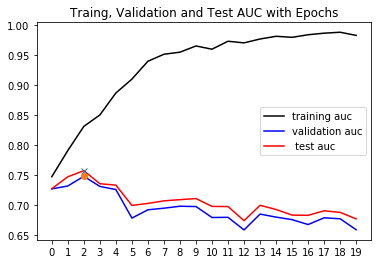

In [30]:
# plotting and diagnose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

#plot all three auc in a same plot
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.xticks(np.arange(0, epochs, 1.0))
plt.legend(loc= 'center right')
train_max = max(train_auc_allep)
test_max = max(test_auc_allep)
valid_max = max(valid_auc_allep)
plt.plot(test_auc_allep.index(test_max),test_max ,'x')
plt.plot(valid_auc_allep.index(valid_max),valid_max, 'o')

plt.show

C:\Users\lgindybekhet\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


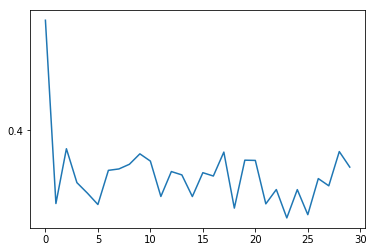

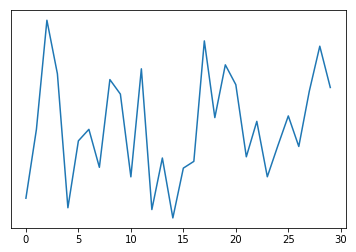

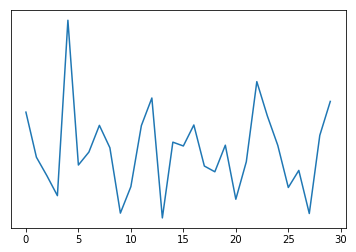

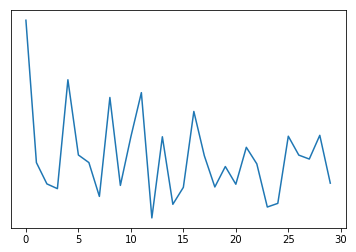

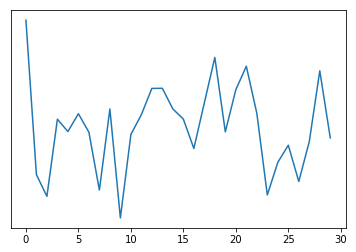

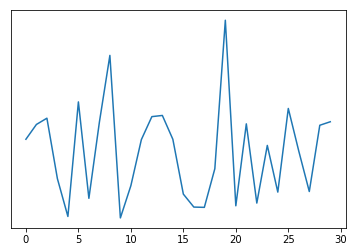

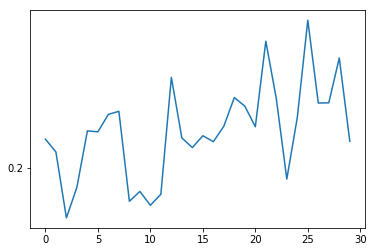

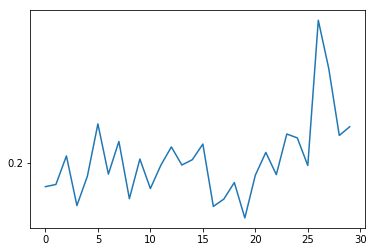

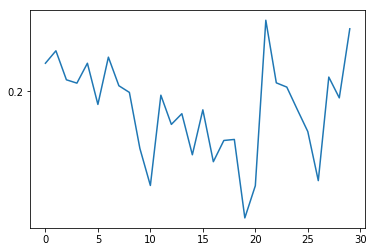

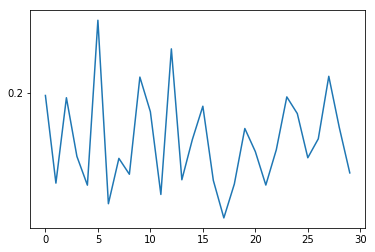

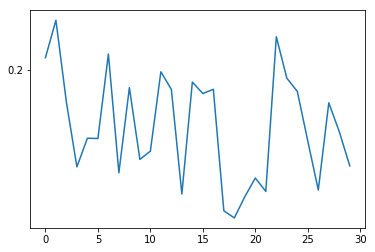

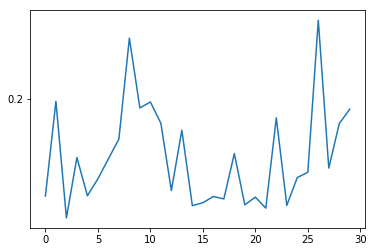

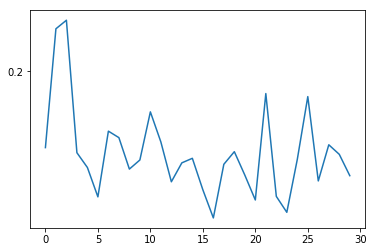

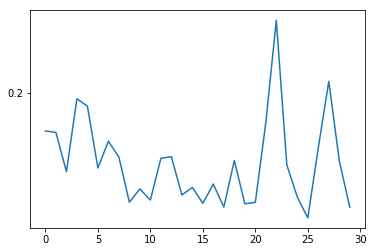

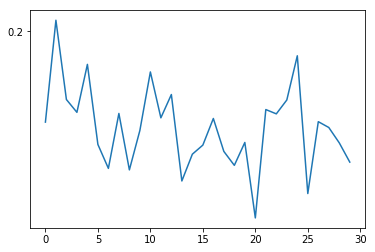

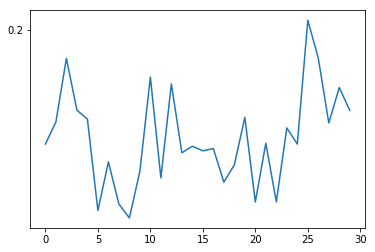

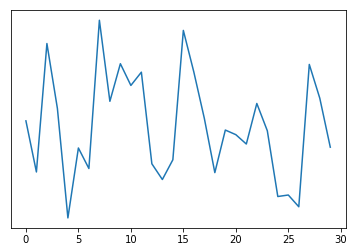

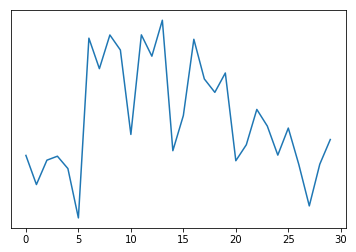

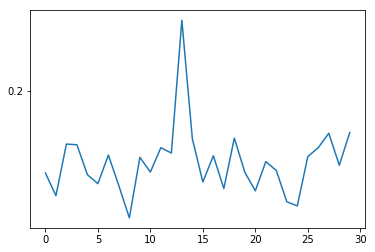

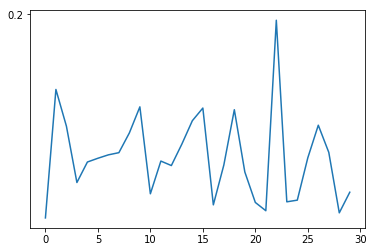

In [13]:
# plotting and diagnose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
for all_losses_a in all_losses_l:
    showPlot(all_losses_a)